
##### Predict the onset if diabetes based on diagnostic measures. use ML algorithm to classify diabetes. plot and display necessary metrics. Use EDA for feature selection and do necessary feature engineering and modeling and evalution parts with explanation


##### Attribute information
Input Varaibles:

- Pregnancies: Number of timed pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- Bloodpressure: Diastolic blood pressure(mm Hg)
- SkinThicness: Triceps skin fold thickness(mm)
- Insulin: 2-Hours serum insulin(mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Output Varaible (Desired Target):

Outcome: 
- has the persom indicated positively diabetic (binary: 1,0)

### Importing Libraies and dataset

In [105]:
# Library
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Feature engineering 
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler



# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,KFold,StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier


# Ignore Warning
import sys
import warnings
warnings.filterwarnings("ignore")

In [106]:
df = pd.read_csv('diabetes.csv')

In [107]:
df.head(6)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0


In [5]:
df.shape

(768, 9)

### Data Conditioning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Modifying column's namees

In [7]:
df = df.rename(columns={
    'Pregnancies': 'pregnancies',
    'Glucose': 'glucose',
    'BloodPressure': 'blood_pressure',
    'SkinThickness': 'skin_thickness',
    'Insulin':'insulin',
    'BMI':'bmi',
    'DiabetesPedigreeFunction': 'diabetes_pedigree',
    'Age': 'age',
    'Outcome': 'y'})

### Exploratory Data Analysis (EDA)

In [8]:
df_eda = df.copy()

In [9]:
df_eda['y'].replace(1, 'yes', inplace = True)
df_eda['y'].replace(0, 'no', inplace = True)

### 1.Missing values, Anamaly, Outlier, Duplicated data detection

In [10]:
listItem = []
for col in df_eda.columns :
    listItem.append([col, df_eda[col].dtype, df_eda[col].isna().sum(), round((df_eda[col].isna().sum()/len(df_eda[col])) * 100,2),
                    df_eda[col].nunique(), list(df_eda[col].drop_duplicates().sample(2).values)]);

df_edaDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
df_edaDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,pregnancies,int64,0,0.0,17,"[9, 2]"
1,glucose,int64,0,0.0,136,"[142, 103]"
2,blood_pressure,int64,0,0.0,47,"[96, 88]"
3,skin_thickness,int64,0,0.0,51,"[32, 37]"
4,insulin,int64,0,0.0,186,"[74, 108]"
5,bmi,float64,0,0.0,248,"[24.9, 39.5]"
6,diabetes_pedigree,float64,0,0.0,517,"[0.624, 0.337]"
7,age,int64,0,0.0,52,"[53, 29]"
8,y,object,0,0.0,2,"[yes, no]"


- There is no missing values indicated in the dataset

In [11]:
df_eda.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


- Several features display a minimun value of 0: glucose, blood_pressure, skin_thickness, insulin and BMI, which are non-sense if the score is 0.
- Eventhough pregnancies have zero minimum which can be true for not having babies.

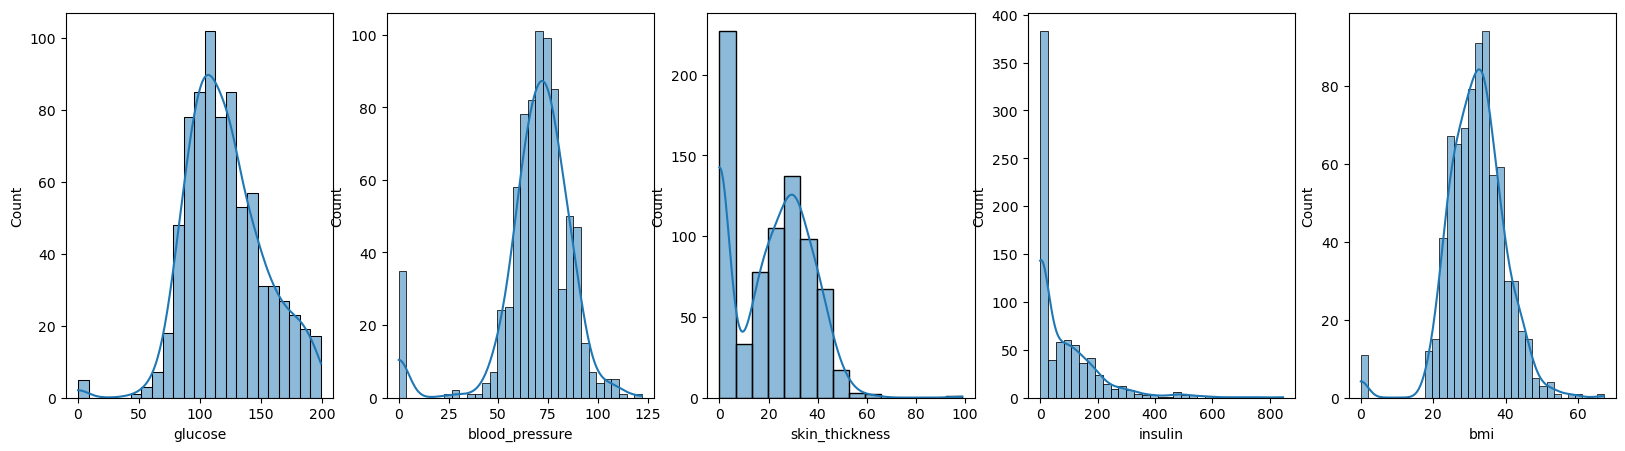

In [12]:
# See data distribution for glucose, blood_pressure, skin_thickness, insulin, and bmi
cols = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']
fig = plt.figure(figsize=(20, 5))
for i in range(len(cols)):
    plt.subplot(1, 5, i+1)
    sns.histplot(df_eda[cols[i]], kde=True)

- As can be seen in data animalies detection we see data in glucose, blood_pressure, skin_thicknes, insulin and BMi have zeros values which does not make sense, since a person do not have zero values of these features.
it probabily happened because of the data imputation process they handle automatically missing values as zeros values so there are no missing values but have zeros values is some of the data points.

In [13]:
zero1 = df_eda[df_eda['glucose'] == 0]
zero2 = df_eda[df_eda['blood_pressure'] == 0]
zero3 = df_eda[df_eda['skin_thickness'] == 0]
zero4 = df_eda[df_eda['insulin'] == 0]
zero5 = df_eda[df_eda['bmi'] == 0]

# Calculate Percentage
zeros = [zero1, zero2, zero3, zero4, zero5]
cols = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']
for i in range(5):
  pct = round(len(zeros[i])/len(df_eda[cols[i]])*100,2)
  print(f'Percentage of zero values in {cols[i]} column is {pct} %')

Percentage of zero values in glucose column is 0.65 %
Percentage of zero values in blood_pressure column is 4.56 %
Percentage of zero values in skin_thickness column is 29.56 %
Percentage of zero values in insulin column is 48.7 %
Percentage of zero values in bmi column is 1.43 %


In [14]:
zero_all = pd.concat([zero1, zero2, zero3, zero4, zero5], axis = 0)
zero_all.drop_duplicates(inplace=True)
zero_all

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y
75,1,0,48,20,0,24.7,0.140,22,no
182,1,0,74,20,23,27.7,0.299,21,no
342,1,0,68,35,0,32.0,0.389,22,no
349,5,0,80,32,0,41.0,0.346,37,yes
502,6,0,68,41,0,39.0,0.727,41,yes
...,...,...,...,...,...,...,...,...,...
756,7,137,90,41,0,32.0,0.391,39,no
761,9,170,74,31,0,44.0,0.403,43,yes
764,2,122,70,27,0,36.8,0.340,27,no
767,1,93,70,31,0,30.4,0.315,23,no


In [15]:
zero_pct = round(zero_all.shape[0]/df_eda.shape[0]*100,2)
print(f'There are {zero_pct} % zero value anomalies in the data')

There are 48.96 % zero value anomalies in the data


In [16]:
knn_impute = KNNImputer(missing_values=0)
df_eda[['glucose', 'blood_pressure', 'skin_thickness', 'insulin',
       'bmi','diabetes_pedigree', 'age']] = knn_impute.fit_transform(df_eda[['glucose', 'blood_pressure', 'skin_thickness', 'insulin',
       'bmi','diabetes_pedigree', 'age']])

- We use KNNImputer to assign 0 value in numerical variable with imputer based on predictive model KNN

In [17]:
df.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


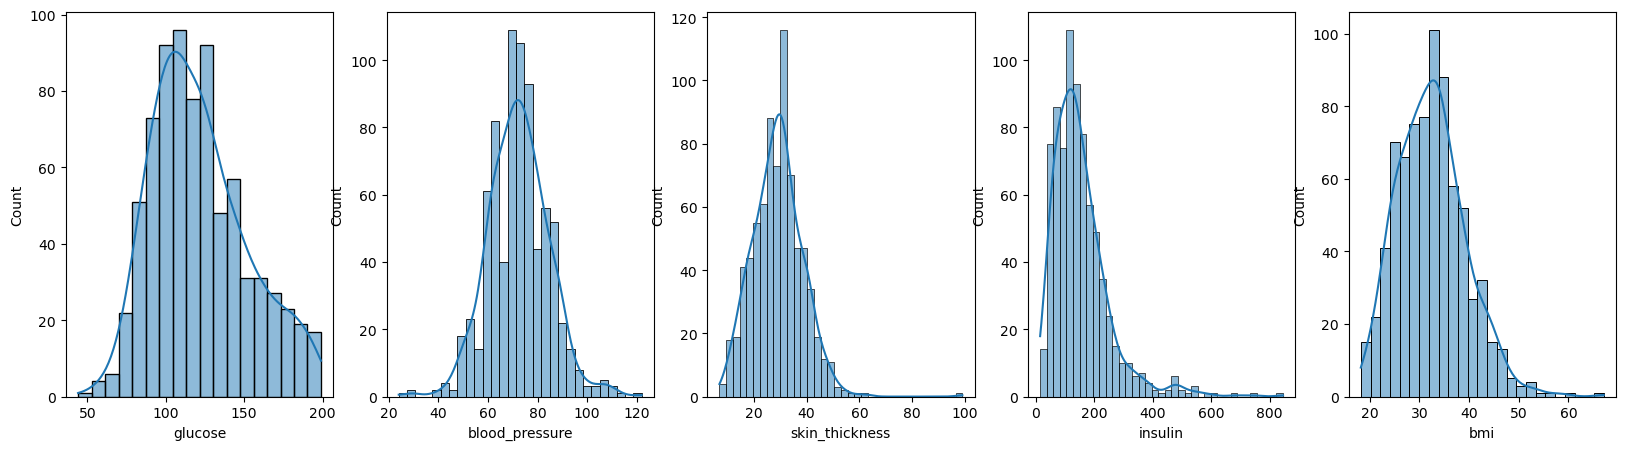

In [18]:
# See data distribution for glucose, blood_pressure, skin_thickness, insulin, and bmi after zero value handling
cols = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']
fig = plt.figure(figsize=(20, 5))
for i in range(len(cols)):
    plt.subplot(1, 5, i+1)
    sns.histplot(df_eda[cols[i]], kde=True)

### Outlier Detection

In [19]:
numerical_cols = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin',
       'bmi', 'diabetes_pedigree', 'age']

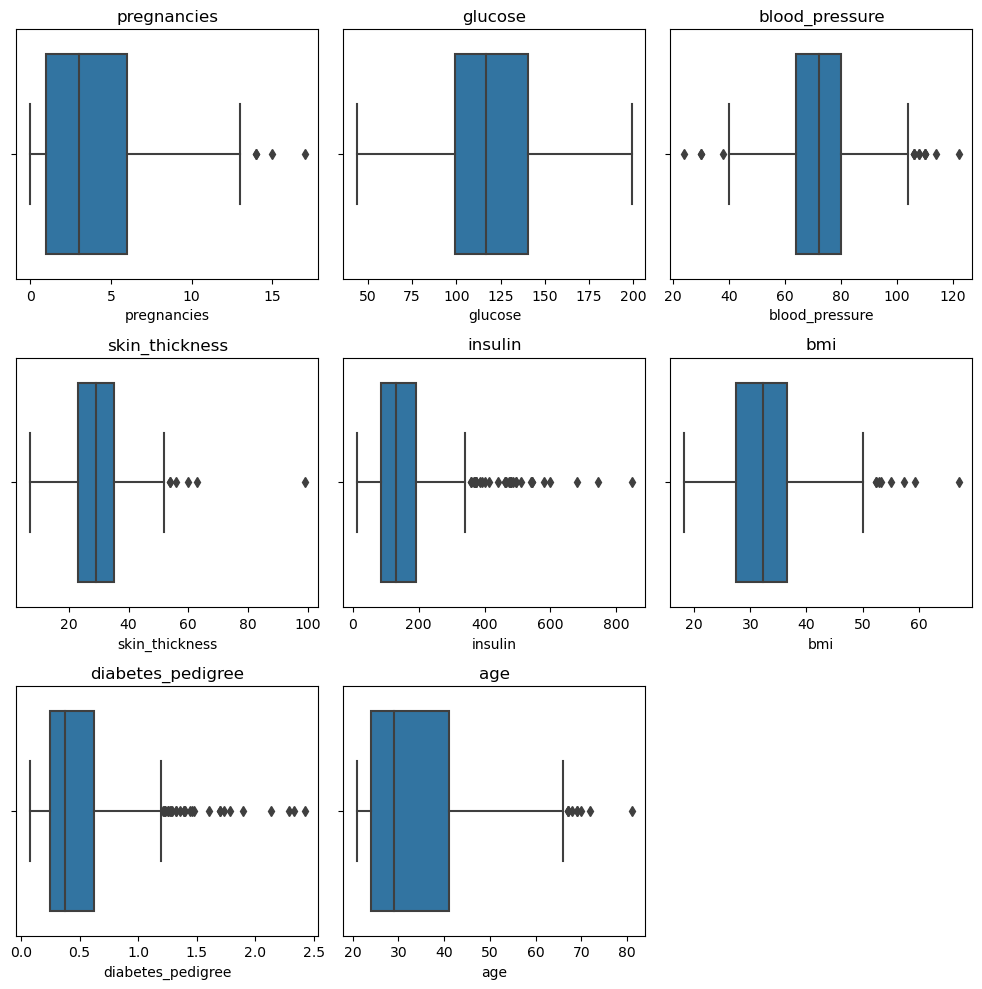

In [20]:
# plot for outliers detection
plt.figure(figsize=(10,10))
for i in range(len(df_eda[numerical_cols].columns)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=df_eda[numerical_cols[i]])
    plt.title(df_eda.columns[i])
    
plt.tight_layout()


In [21]:
# creating function to generate IQR, lower limit, and Upper limit

def find_outlier(df, feature):
    print('Outlier ' + feature)
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    limit = iqr*1.5
    print(f'IQR: {iqr}')

    Lower_Limit = q1 - limit
    Upper_Limit = q3 + limit
    print(f'Lower_Limit: {Lower_Limit}')
    print(f'Upper_Limit: {Upper_Limit}')
    print('_________________________')

In [22]:
# check IQR, upper limit, and lower limit for each feature

for i in df_eda.drop(columns=['y']) :
    find_outlier(df_eda, i)

Outlier pregnancies
IQR: 5.0
Lower_Limit: -6.5
Upper_Limit: 13.5
_________________________
Outlier glucose
IQR: 41.25
Lower_Limit: 37.125
Upper_Limit: 202.125
_________________________
Outlier blood_pressure
IQR: 16.0
Lower_Limit: 40.0
Upper_Limit: 104.0
_________________________
Outlier skin_thickness
IQR: 12.0
Lower_Limit: 5.0
Upper_Limit: 53.0
_________________________
Outlier insulin
IQR: 103.60000000000002
Lower_Limit: -67.95000000000005
Upper_Limit: 346.45000000000005
_________________________
Outlier bmi
IQR: 9.100000000000001
Lower_Limit: 13.849999999999998
Upper_Limit: 50.25
_________________________
Outlier diabetes_pedigree
IQR: 0.38249999999999995
Lower_Limit: -0.32999999999999996
Upper_Limit: 1.2
_________________________
Outlier age
IQR: 17.0
Lower_Limit: -1.5
Upper_Limit: 66.5
_________________________


In [23]:
# creating outliers columns
out1 = df_eda[df_eda['pregnancies'] > 13.5]
out2 = df_eda[(df_eda['glucose'] < 37.125) & (df_eda['glucose'] > 202.125)]
out3 = df_eda[(df_eda['blood_pressure'] < 40) & (df_eda['blood_pressure'] > 104)]
out4 = df_eda[(df_eda['skin_thickness'] < 5) & (df_eda['skin_thickness'] > 53)]
out5 = df_eda[df_eda['insulin'] > 346.45]
out6 = df_eda[(df_eda['bmi'] < 13.85) & (df_eda['bmi'] > 50.25)]
out7 = df_eda[df_eda['diabetes_pedigree'] > 1.2]
out8 = df_eda[df_eda['age'] > 66.5]



In [24]:
# creating outliers dataframe

out_all = pd.concat([out1, out2, out3, out4, out5, out6, out7, out8], axis = 0)
out_all.drop_duplicates(inplace=True)
out_all

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y
88,15,136.0,70.0,32.0,110.0,37.1,0.153,43.0,yes
159,17,163.0,72.0,41.0,114.0,40.9,0.817,47.0,yes
298,14,100.0,78.0,25.0,184.0,36.6,0.412,46.0,yes
455,14,175.0,62.0,30.0,159.8,33.6,0.212,38.0,yes
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53.0,yes
...,...,...,...,...,...,...,...,...,...
459,9,134.0,74.0,33.0,60.0,25.9,0.460,81.0,no
537,0,57.0,60.0,31.8,108.4,21.7,0.735,67.0,no
666,4,145.0,82.0,18.0,149.2,32.5,0.235,70.0,yes
674,8,91.0,82.0,31.4,142.6,35.6,0.587,68.0,no


In [25]:
#check outliers percentage

print('Percentage Outlier')
len(out_all)/len(df_eda)*100

Percentage Outlier


9.114583333333332

In [26]:
df_eda.drop(labels=out_all.index, axis=0, inplace=True)

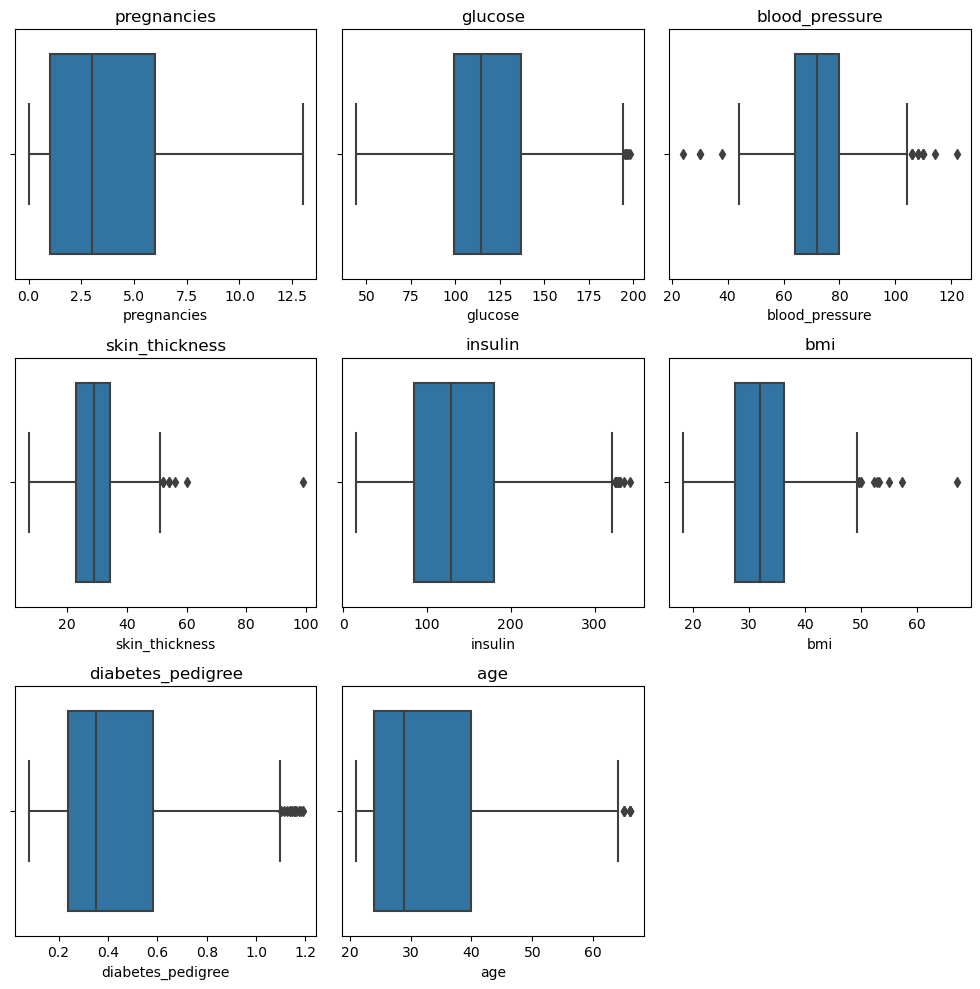

In [27]:
# plot for outliers detection after removing outliers
plt.figure(figsize=(10,10))
for i in range(len(df_eda[numerical_cols].columns)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=df_eda[numerical_cols[i]])
    plt.title(df_eda.columns[i])
    
plt.tight_layout()

### Checking for duplicated values

In [28]:
#check whether there is any duplicate value
df_eda[df_eda.duplicated()]

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y


- There is no duplication in this data set

### 2. Feature Engineering

#### a.Weight status

In [29]:
# Here's the weight Classification based on BMI score:
#|-------------------------------------------|
# |       BMI Class       |     BMI Range     |
# |-----------------------|-------------------|
# |   Underweight         | < 18.5            |
# |   Healthy weight      | 18.5 - 24.9       |
# |   Overweight          | 25 - 29.9         |
# |   Obesity 1           | 30 - 34.9         |
# |   Obesity 2           | 35 - 39.9         |
# |   Obesity 3           | > 40.0            |
# |-----------------------|-------------------|
#  Source: Centers for Disease Control and Prevention

In [30]:
bmi_bins = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")

df_eda['bmi_group'] = bmi_bins

df_eda.loc[df_eda['bmi'] < 18.5, 'bmi_group'] = bmi_bins[0]
df_eda.loc[(df_eda['bmi'] >= 18.5) & (df_eda['bmi'] <= 24.9), 'bmi_group'] = bmi_bins[1]
df_eda.loc[(df_eda['bmi'] > 24.9) & (df_eda['bmi'] <= 29.9), 'bmi_group'] = bmi_bins[2]
df_eda.loc[(df_eda['bmi'] > 29.9) & (df_eda['bmi'] <= 34.9), 'bmi_group'] = bmi_bins[3]
df_eda.loc[(df_eda['bmi'] > 34.9) & (df_eda['bmi'] <= 39.9), 'bmi_group'] = bmi_bins[4]
df_eda.loc[df_eda['bmi'] > 39.9 ,'bmi_group'] = bmi_bins[5]
df_eda['bmi_group'].unique()


['Obesity 1', 'Overweight', 'Normal', 'Obesity 2', 'Obesity 3', 'Underweight']
Categories (6, object): ['Normal', 'Obesity 1', 'Obesity 2', 'Obesity 3', 'Overweight', 'Underweight']

In [31]:
df_eda.sample(5)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y,bmi_group
733,2,106.0,56.0,27.0,165.0,29.0,0.426,22.0,no,Overweight
285,7,136.0,74.0,26.0,135.0,26.0,0.647,51.0,no,Overweight
696,3,169.0,74.0,19.0,125.0,29.9,0.268,31.0,yes,Overweight
633,1,128.0,82.0,17.0,183.0,27.5,0.115,22.0,no,Overweight
576,6,108.0,44.0,20.0,130.0,24.0,0.813,35.0,no,Normal


#### b. Insulin Status

In [32]:
# Here's the insulin status based on 2-Hour serum insulin Level (1 IU/L = 1 mIU/mL):

# |-----------------------------------------|
# |  Diabetes Diagnostic  | Insulin (IU/L)  |
# |-----------------------|-----------------|
# |  Normal               |  16-166 mIU/L   |
# |-----------------------|-----------------|
# Source: Diabetes Education Online

In [33]:
insulin_bins = pd.Series(['Abnormal', 'Normal', 'Abnormal'], dtype = "category")

df_eda['insulin_stat'] = insulin_bins

df_eda.loc[df_eda['insulin'] < 16, 'insulin_stat'] = insulin_bins[0]
df_eda.loc[(df_eda['insulin'] >= 16) & (df_eda['insulin'] <= 166), 'insulin_stat'] = insulin_bins[1]
df_eda.loc[df_eda['insulin'] > 166 ,'insulin_stat'] = insulin_bins[2]

df_eda['insulin_stat'].unique()

['Abnormal', 'Normal']
Categories (2, object): ['Abnormal', 'Normal']

In [34]:
df_eda.sample(10)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y,bmi_group,insulin_stat
221,2,158.0,90.0,30.0,188.6,31.60,0.805,66.0,yes,Obesity 1,Abnormal
603,7,150.0,78.0,29.0,126.0,35.20,0.692,54.0,yes,Obesity 2,Normal
426,0,94.0,72.2,28.0,54.6,32.18,0.256,25.0,no,Obesity 1,Normal
444,4,117.0,62.0,12.0,125.2,29.70,0.380,30.0,yes,Overweight,Normal
38,2,90.0,68.0,42.0,113.4,38.20,0.503,27.0,yes,Obesity 2,Normal
406,4,115.0,72.0,23.4,191.8,28.90,0.376,46.0,yes,Overweight,Abnormal
526,1,97.0,64.0,19.0,82.0,18.20,0.299,21.0,no,Underweight,Normal
240,1,91.0,64.0,24.0,66.6,29.20,0.192,21.0,no,Overweight,Normal
483,0,84.0,82.0,31.0,125.0,38.20,0.233,23.0,no,Obesity 2,Normal
420,1,119.0,88.0,41.0,170.0,45.30,0.507,26.0,no,Obesity 3,Abnormal


#### c. Glucose Status

In [35]:
# Here's the diabetes diagnostic criteria based on 2-hr Oral Glucose Tolerance Test (OGTT) Glucose Level:

# |-----------------------------------------|
# |  Diabetes Diagnostic  | Glucose (mg/dl) |
# |-----------------------|-----------------|
# |  Normal               |     < 140       |
# |  Pre-diabetes         |    140-199      |
# |  Diabetes             |     > 199       |
# |-----------------------|-----------------|
# Source: Diabetes Education Online

In [36]:
glucose_bins = pd.Series(['Normal', 'Pre-diabetes', 'Diabetes'], dtype = "category")

df_eda['glucose_stat'] = glucose_bins

df_eda.loc[df_eda['glucose'] < 140, 'glucose_stat'] = glucose_bins[0]
df_eda.loc[(df_eda['glucose'] >= 140) & (df_eda['glucose'] <= 199), 'glucose_stat'] = glucose_bins[1]
df_eda.loc[df_eda['glucose'] > 199 ,'glucose_stat'] = glucose_bins[2]

df_eda['glucose_stat'].unique()

['Pre-diabetes', 'Normal']
Categories (3, object): ['Diabetes', 'Normal', 'Pre-diabetes']

In [37]:
df_eda.sample(10)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y,bmi_group,insulin_stat,glucose_stat
675,6,195.0,70.0,30.8,329.6,30.9,0.328,31.0,yes,Obesity 1,Abnormal,Pre-diabetes
730,3,130.0,78.0,23.0,79.0,28.4,0.323,34.0,yes,Overweight,Normal,Normal
277,0,104.0,64.0,23.0,116.0,27.8,0.454,23.0,no,Overweight,Normal,Normal
14,5,166.0,72.0,19.0,175.0,25.8,0.587,51.0,yes,Overweight,Abnormal,Pre-diabetes
620,2,112.0,86.0,42.0,160.0,38.4,0.246,28.0,no,Obesity 2,Normal,Normal
750,4,136.0,70.0,29.4,124.0,31.2,1.182,22.0,yes,Obesity 1,Normal,Normal
163,2,100.0,64.0,23.0,85.2,29.7,0.368,21.0,no,Overweight,Normal,Normal
322,0,124.0,70.0,20.0,109.6,27.4,0.254,36.0,yes,Overweight,Normal,Normal
94,2,142.0,82.0,18.0,64.0,24.7,0.761,21.0,no,Normal,Normal,Pre-diabetes
349,5,132.8,80.0,32.0,140.6,41.0,0.346,37.0,yes,Obesity 3,Normal,Normal


#### d. Blood Pressure Status

In [38]:
# Here's the Blood Pressure Category based on Diastolic blood pressure (mm Hg):

# |----------------------------------------------------------|
# | Blood Pressure Status | Diastolic blood pressure (mm Hg) |
# |-----------------------|----------------------------------|
# | Normal                |               < 80               |
# | Hypertension Stage 1  |              80 - 89             |
# | Hypertension Stage 2  |               > 89               |
# |-----------------------|----------------------------------|
# Source: Centers for Disease Control and Prevention

In [39]:
blood_pressure_bins = pd.Series(['Normal', 'Hypertension Stage 1', 'Hypertension Stage 2'], dtype = "category")

df_eda['blood_pressure_stat'] = blood_pressure_bins

df_eda.loc[df_eda['blood_pressure'] < 80, 'blood_pressure_stat'] = blood_pressure_bins[0]
df_eda.loc[(df_eda['blood_pressure'] >= 80) & (df_eda['blood_pressure'] <= 89), 'blood_pressure_stat'] = blood_pressure_bins[1]
df_eda.loc[df_eda['blood_pressure'] > 89 ,'blood_pressure_stat'] = blood_pressure_bins[2]

df_eda['blood_pressure_stat'].unique()

['Normal', 'Hypertension Stage 2', 'Hypertension Stage 1']
Categories (3, object): ['Hypertension Stage 1', 'Hypertension Stage 2', 'Normal']

In [40]:
df_eda.sample(10)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y,bmi_group,insulin_stat,glucose_stat,blood_pressure_stat
331,2,87.0,58.0,16.0,52.0,32.70,0.166,25.0,no,Obesity 1,Normal,Normal,Normal
31,3,158.0,76.0,36.0,245.0,31.60,0.851,28.0,yes,Obesity 1,Abnormal,Pre-diabetes,Normal
222,7,119.0,73.6,25.0,133.0,25.20,0.209,37.0,no,Overweight,Normal,Normal,Normal
106,1,96.0,122.0,29.8,73.0,22.40,0.207,27.0,no,Normal,Normal,Normal,Hypertension Stage 2
457,5,86.0,68.0,28.0,71.0,30.20,0.364,24.0,no,Obesity 1,Normal,Normal,Normal
307,0,137.0,68.0,14.0,148.0,24.80,0.143,21.0,no,Normal,Normal,Normal,Normal
152,9,156.0,86.0,28.0,155.0,34.30,1.189,42.0,yes,Obesity 1,Normal,Pre-diabetes,Hypertension Stage 1
754,8,154.0,78.0,32.0,144.8,32.40,0.443,45.0,yes,Obesity 1,Normal,Pre-diabetes,Normal
49,7,105.0,61.6,29.4,118.4,31.02,0.305,24.0,no,Obesity 1,Normal,Normal,Normal
707,2,127.0,46.0,21.0,335.0,34.40,0.176,22.0,no,Obesity 1,Abnormal,Normal,Normal


## 3. Univariate analysis

#### Key Point:

- 32.4% of patients in this dataset have diabetes, there is no imbalance class detected. 1

In [41]:
df_numeric = df_eda.select_dtypes(include='number')

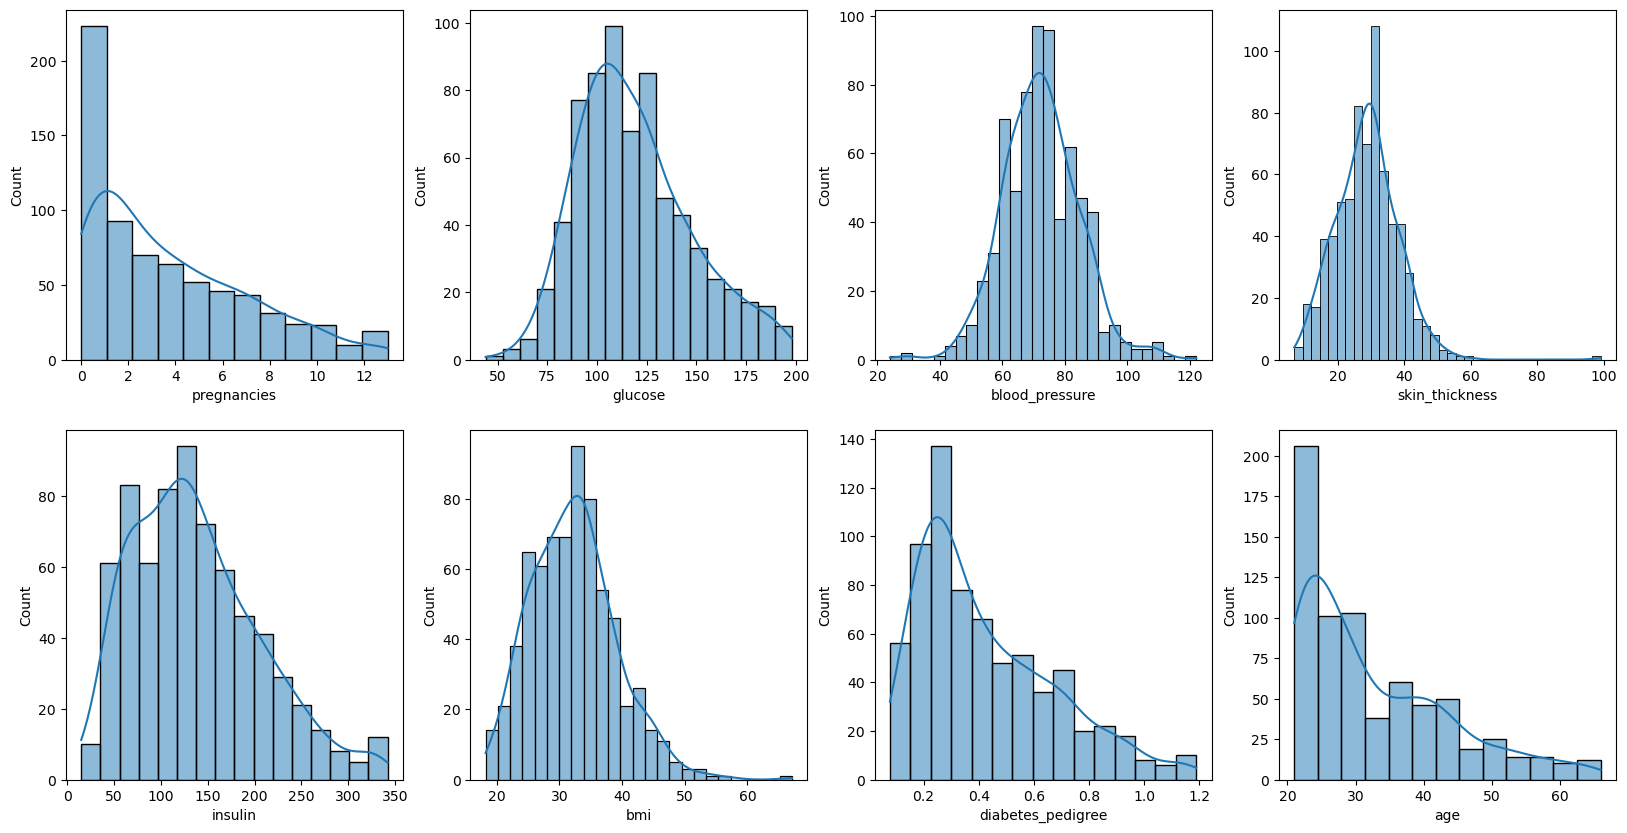

In [42]:
# creating distribution plot for analysis
fig = plt.figure(figsize=(20, 10))
for i in range(len(df_numeric.columns)):
    plt.subplot(2, 4, i+1)
    sns.histplot(df_numeric[df_numeric.columns[i]], kde=True)

In [43]:
# creating function for detailed descriptive analytic
def summary_stats(df, n=4):
    # central tendency: mean, median
    mean = pd.DataFrame(df.apply(np.mean)).T
    median = pd.DataFrame(df.apply(np.median)).T

    # distribution: ,std, min, max, range, skew, kurtosis
    std = pd.DataFrame(df.apply(np.std)).T
    min_value = pd.DataFrame(df.apply(min)).T
    max_value = pd.DataFrame(df.apply(max)).T
    range_value = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    skewness = pd.DataFrame(df.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    # concatenates
    summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
    summary_stats.columns = ['attributes','min','max', 'range','mean','median', 'std','skewness','kurtosis']
    
    return round(summary_stats, n)

In [44]:
summary_stats(df_numeric)

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,pregnancies,0.000,13.000,13.000,3.8023,3.0000,3.2877,0.8406,-0.1068
1,glucose,44.000,198.000,154.000,119.0931,114.5000,28.8174,0.5822,-0.0714
2,blood_pressure,24.000,122.000,98.000,72.3072,72.0000,12.2538,0.1938,1.0626
3,skin_thickness,7.000,99.000,92.000,28.8384,29.0000,9.3252,0.7181,4.0924
4,insulin,15.000,342.000,327.000,137.3819,128.4000,67.9570,0.6784,0.0488
5,bmi,18.200,67.100,48.900,32.2603,32.0000,6.7956,0.5959,0.9291
6,diabetes_pedigree,0.078,1.189,1.111,0.4273,0.3515,0.2486,0.9320,0.1709
7,age,21.000,66.000,45.000,32.6605,29.0000,11.0406,1.0547,0.3358


- Normality Range Criteria baased on skewness and kurtosis: The values for asymmetry and kurtosis between -2 and +2 are considered acceptable in order to prove normal univariate distribution (George & Mallery, 2010). Hair et al. (2010) and Bryne (2010) argued that data is considered to be normal if skewness is between ‐2 to +2 and kurtosis is between ‐7 to +7.

Source: Cambridge University

##### Features distribution:

- Symetric: glucose, blood_pressure, skin_thickness, bmi.
- Right Skewed: pregnancies, insulin, diabetes_predigree, age.

### Percentage of Output Class

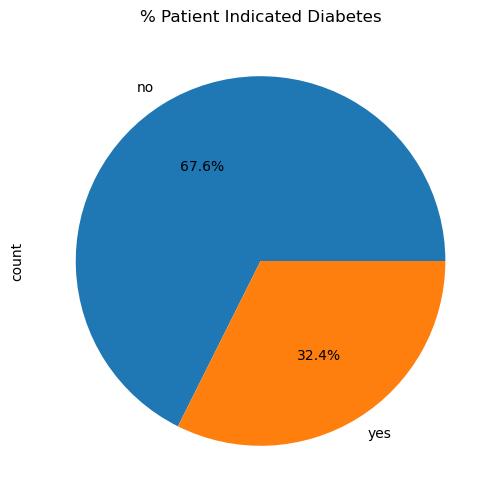

In [47]:
plt.figure(figsize=(8,6)) 
plt.title('% Patient Indicated Diabetes')
df_eda['y'].value_counts().plot(kind = "pie", autopct='%1.1f%%')
plt.show()

- We can see that 32.4% of the patients indicated diabetes.
- The dataset does not indicate an imbalance class between those who have diabetes and those who don't.

### 4. Bivariate Analysis

In [48]:
df_eda1 = df_eda.copy()
df_eda1['y'].replace('yes', 1, inplace = True)
df_eda1['y'].replace('no', 0, inplace = True)
df_eda1.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y,bmi_group,insulin_stat,glucose_stat,blood_pressure_stat
0,6,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1,Obesity 1,Abnormal,Pre-diabetes,Normal
1,1,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0,Overweight,Normal,Normal,Normal
2,8,183.0,64.0,23.4,174.6,23.3,0.672,32.0,1,Normal,Abnormal,Pre-diabetes,Normal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight,Normal,Normal,Normal
5,5,116.0,74.0,20.2,98.0,25.6,0.201,30.0,0,Overweight,Normal,Normal,Normal


In [49]:
df_eda1.select_dtypes(include='number').head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y
0,6,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1
1,1,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0
2,8,183.0,64.0,23.4,174.6,23.3,0.672,32.0,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
5,5,116.0,74.0,20.2,98.0,25.6,0.201,30.0,0


#### Analysis Between Numerical Feature
##### Pair Plot between Numerical features

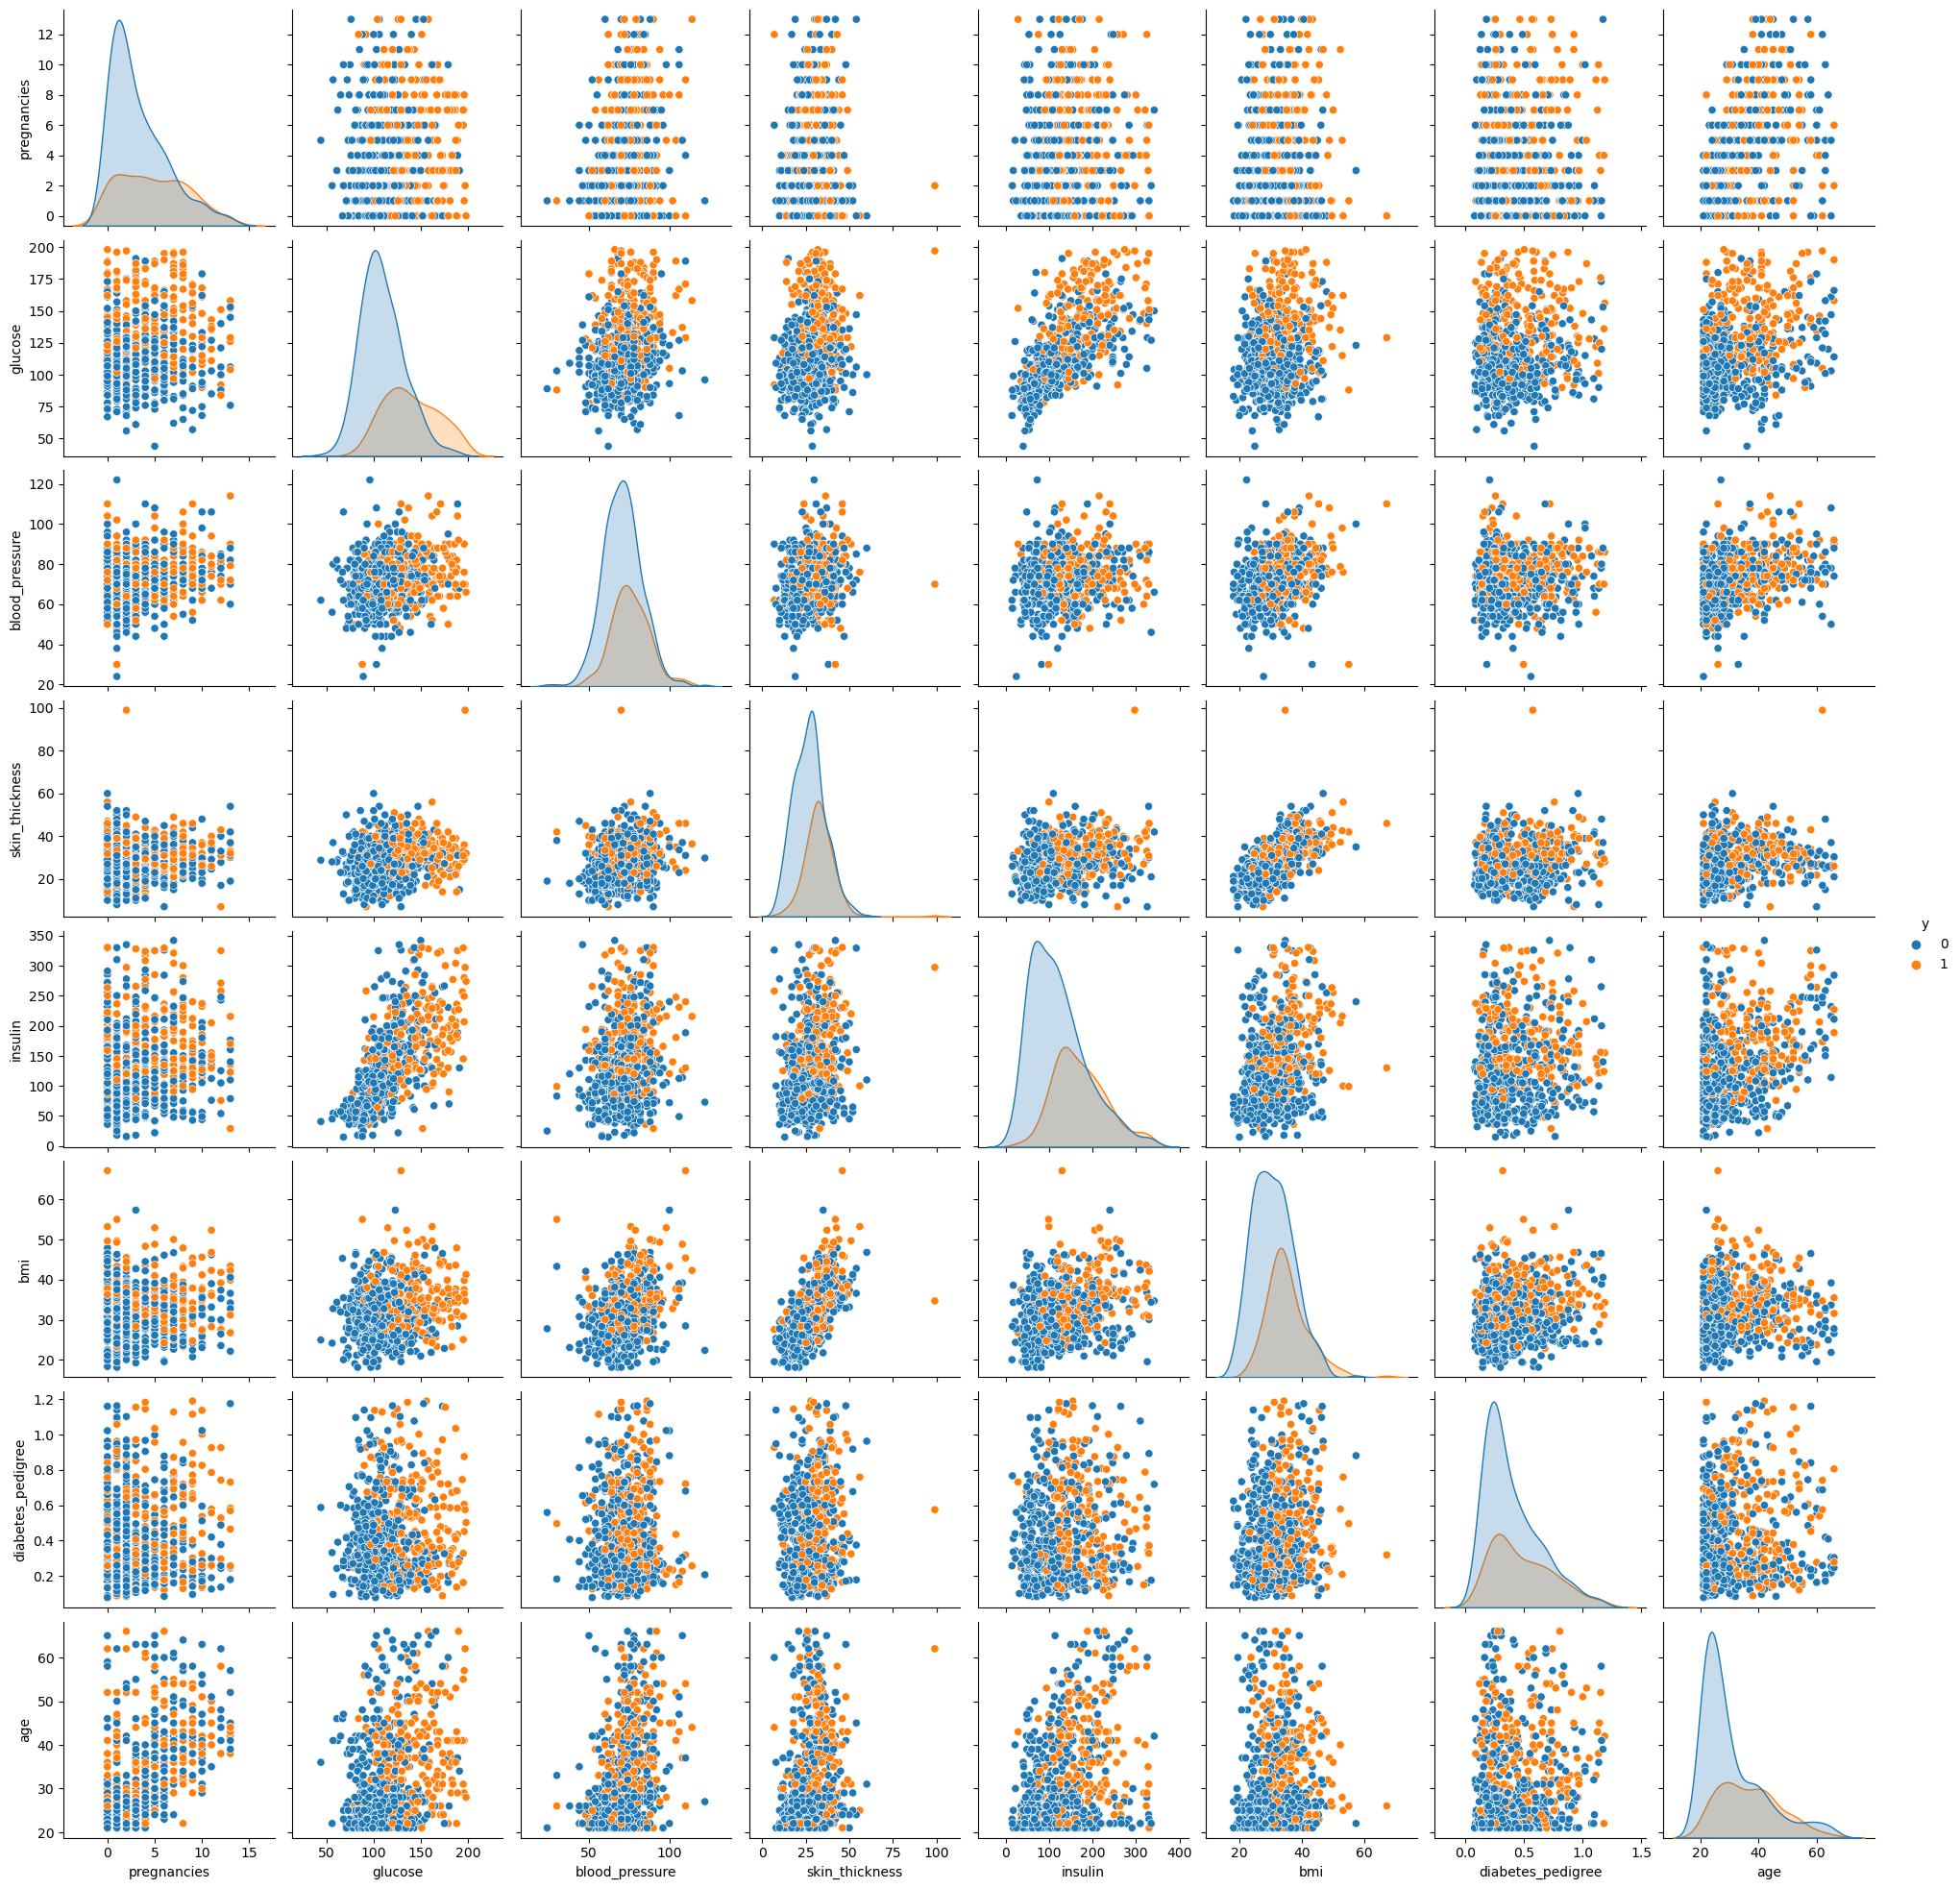

In [50]:
sns.pairplot(data = df_eda1.select_dtypes(include='number'), hue = 'y')
plt.show()

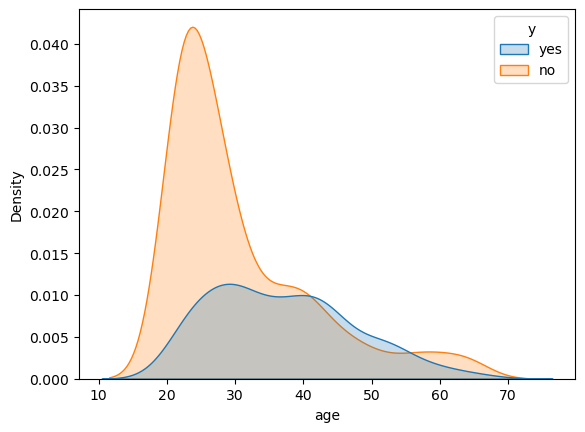

In [51]:
sns.kdeplot(x='age', hue = 'y', data = df_eda, fill=True)
plt.show()

##### Diabetes Outcome by Blood Glucose Level, BMI, and Age

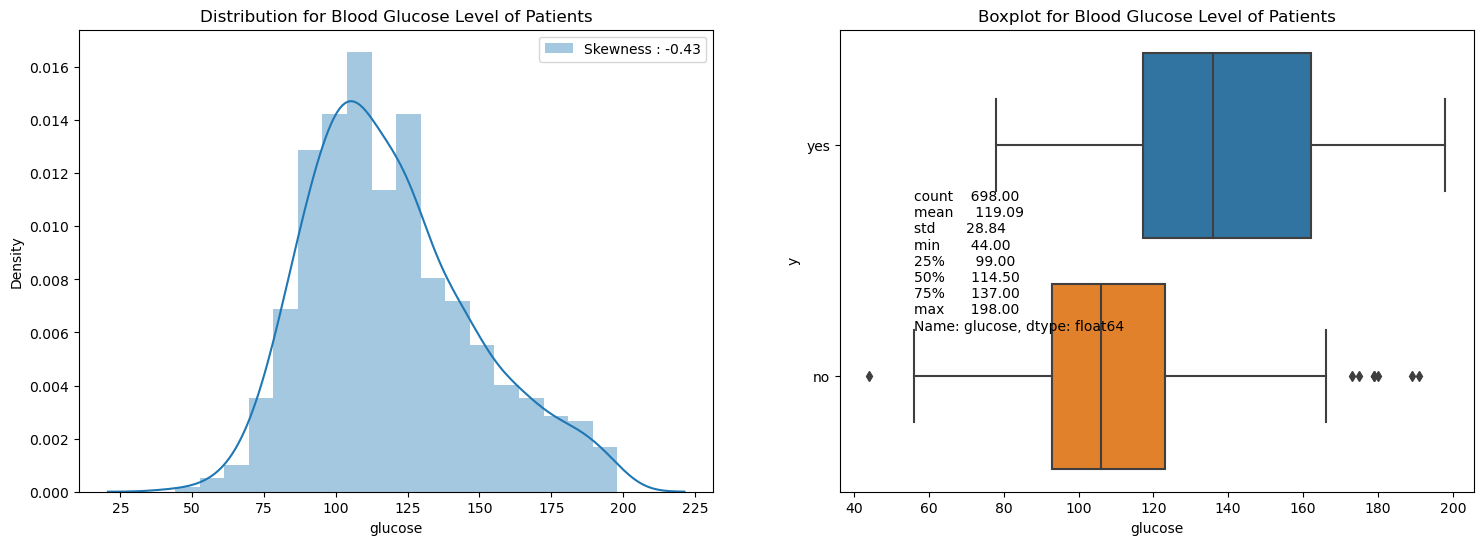

In [52]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
sns.distplot(df_eda['glucose'], label = 'Skewness : %.2f'%(df['bmi'].skew()))
plt.legend(loc = 0, fontsize = 10)
plt.title('Distribution for Blood Glucose Level of Patients')
plt.subplot(1,2,2)
sns.boxplot(x = 'glucose', y = 'y', data = df_eda)
plt.title('Boxplot for Blood Glucose Level of Patients')
glucose = str(df_eda['glucose'].describe().round(2))
plt.text(56, 0.80, glucose)
plt.show()

- Based on blood glucose levels, patients with diabetes have higher blood glucose levels than patients without diabetes

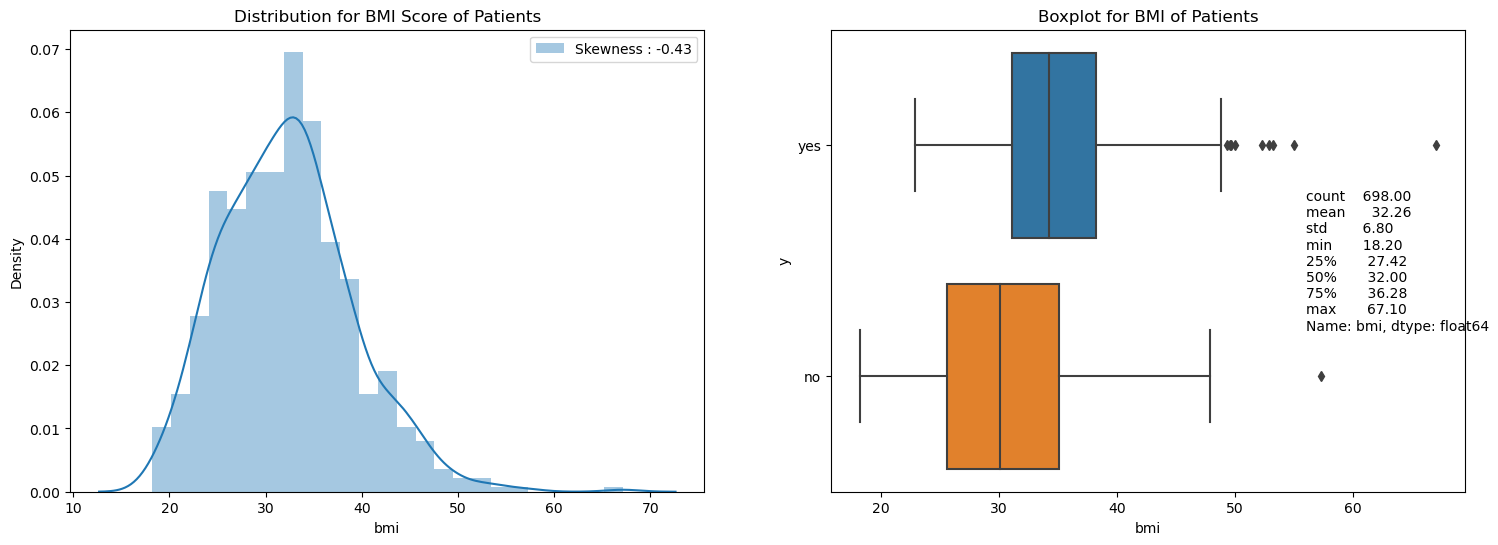

In [53]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
sns.distplot(df_eda['bmi'], label = 'Skewness : %.2f'%(df['bmi'].skew()))
plt.legend(loc = 0, fontsize = 10)
plt.title('Distribution for BMI Score of Patients')
plt.subplot(1,2,2)
sns.boxplot(x = 'bmi', y = 'y', data = df_eda)
plt.title('Boxplot for BMI of Patients')
bmi = str(df_eda['bmi'].describe().round(2))
plt.text(56, 0.80, bmi)
plt.show()

- Based on the BMI, patients with diabetes have higher BMI than patients without diabetes

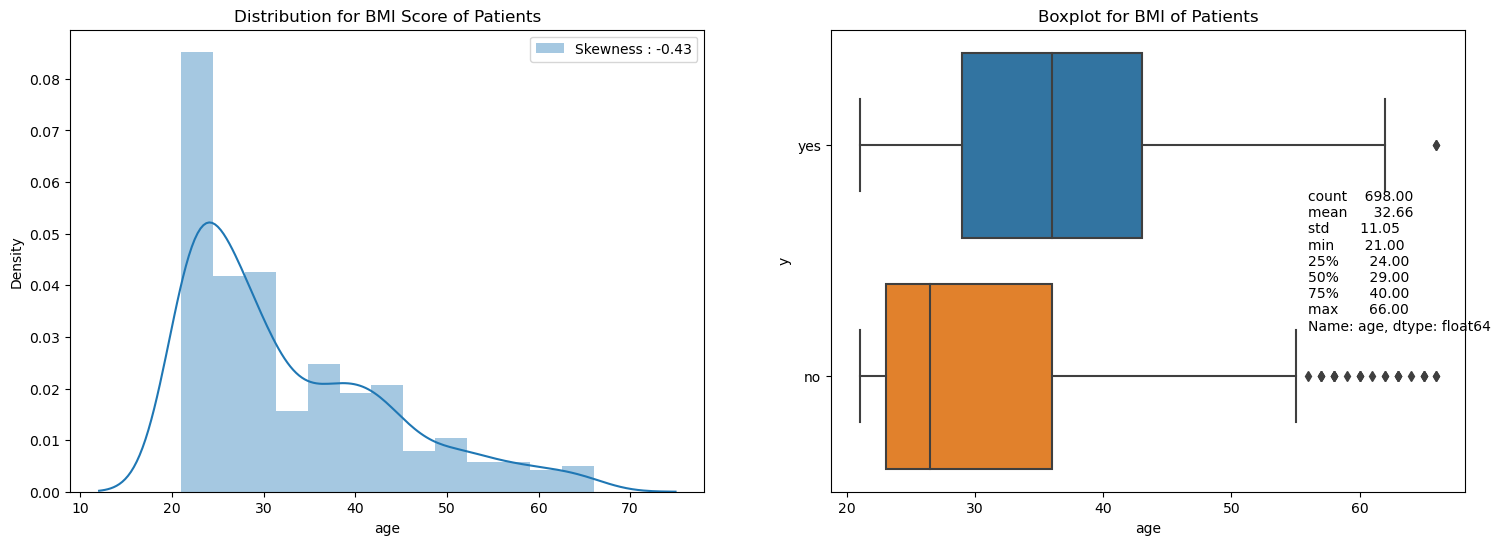

In [54]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
sns.distplot(df_eda['age'], label = 'Skewness : %.2f'%(df['bmi'].skew()))
plt.legend(loc = 0, fontsize = 10)
plt.title('Distribution for BMI Score of Patients')
plt.subplot(1,2,2)
sns.boxplot(x = 'age', y = 'y', data = df_eda)
plt.title('Boxplot for BMI of Patients')
age = str(df_eda['age'].describe().round(2))
plt.text(56, 0.80, age)
plt.show()

- We can see that older patients are more likely to have diabetes than younger patients

#### Exploration to BMI Class

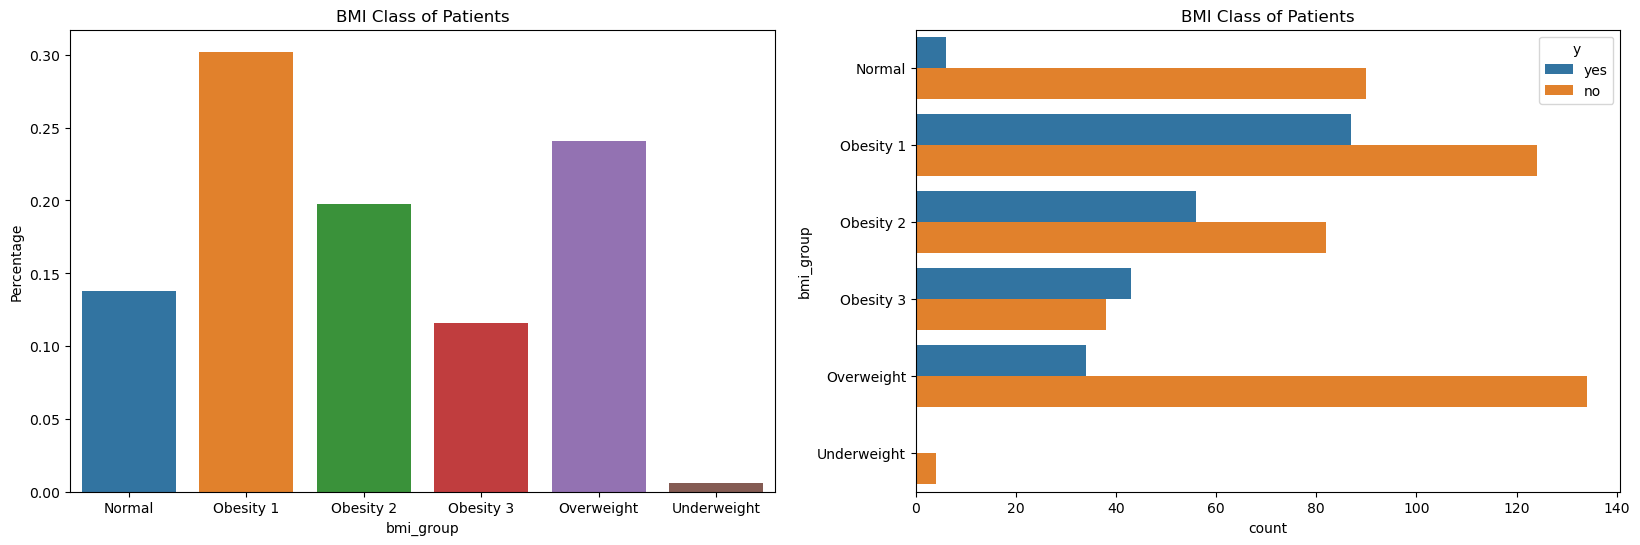

In [55]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
eda_percentage = df_eda['bmi_group'].value_counts(normalize = True).rename_axis('bmi_group').reset_index(name = 'Percentage')
sns.barplot(x = 'bmi_group', y = 'Percentage', data = eda_percentage.head(10))
plt.title('BMI Class of Patients')
plt.subplot(1,2,2)
sns.countplot(data=df_eda, y='bmi_group', hue = df_eda['y'])
plt.title('BMI Class of Patients')
plt.show()

### 5. Multivariate Analysis

In [56]:
df_eda1.select_dtypes(include=np.number)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,y
0,6,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1
1,1,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0
2,8,183.0,64.0,23.4,174.6,23.3,0.672,32.0,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
5,5,116.0,74.0,20.2,98.0,25.6,0.201,30.0,0
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0
764,2,122.0,70.0,27.0,165.0,36.8,0.340,27.0,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0
766,1,126.0,60.0,33.4,134.2,30.1,0.349,47.0,1


### Correlation Between Variables

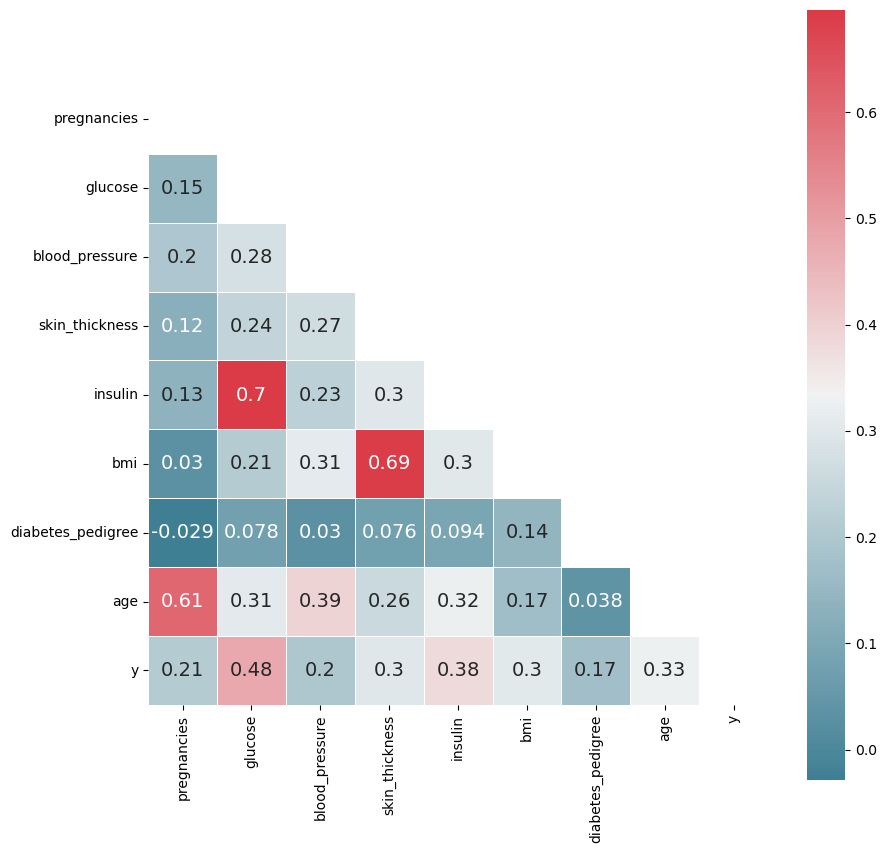

In [57]:
# calculates the correlations
correlation = df_eda1.select_dtypes(include=np.number).corr(method= 'spearman')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 10)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=np.bool_))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(correlation, cmap=cmap, mask=mask, square=True, linewidths=.5, 
            annot=True, annot_kws={'size':14})

# displays the plot
plt.show()


##### Degree of Correlation
- Strong : 0.50 - 1.00
- Medium : 0.30 - 0.49
- Small : < + 0.29

Source: Statistic Solution

- All of variable have correlation with y varible (Diabetes), but the degree correlation are vary from small to medium (there are no variable that have a strong correlation with diabetes).
- There are data multi-collinearity indicated from the dataset. 'age' and 'pregnancies' with corr 0.61; 'insulin' and 'skin_thickness' with corr 0.54; 'bmi' and 'skin_thickness' with corr 0.44.
- Variables that have medium correlation with diabetes are : glucose (+), bmi (+), and age (+).
- glucose, bmi, and age have (+) correlation, this means that if these variables increase, the y variable tend to increase. There are also a (+) correlation between pregnancies, blood_pressure, skin_thickness, insulin, and diabetes_predigree with y (small corr.)


In [86]:
X = df_eda1.drop(columns=['insulin', 'glucose', 'bmi', 'blood_pressure', 'y'])
y = df_eda1['y']

# Train-Test Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state = 2024)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((558, 8), (140, 8), (558,), (140,))

In [87]:
df_eda['blood_pressure_stat'].value_counts()

blood_pressure_stat
Normal                  510
Hypertension Stage 1    133
Hypertension Stage 2     55
Name: count, dtype: int64

In [88]:
tnf1 = ColumnTransformer(transformers=[
    ('tnf5',OrdinalEncoder(categories=[['Normal','Hypertension Stage 1','Hypertension Stage 2']]),['blood_pressure_stat']),
    ('tnf6',OrdinalEncoder(categories=[['Underweight','Normal','Overweight','Obesity 1','Obesity 2','Obesity 3']]),['bmi_group']),
    ('tnf7',OneHotEncoder(sparse=False, drop='first'), ['glucose_stat','insulin_stat'])
],remainder='passthrough')

In [89]:
print(tnf1.fit_transform(X_train))

[[ 0.     3.     0.    ... 29.4    1.182 22.   ]
 [ 1.     4.     0.    ... 36.2    0.304 51.   ]
 [ 0.     3.     0.    ... 26.     0.591 25.   ]
 ...
 [ 0.     5.     0.    ... 52.     0.677 25.   ]
 [ 0.     2.     1.    ... 17.     0.433 27.   ]
 [ 1.     2.     1.    ... 27.     0.189 27.   ]]


In [90]:
tnf1.transform(X_test)

array([[ 1.   ,  4.   ,  1.   , ..., 48.   ,  1.001, 51.   ],
       [ 0.   ,  3.   ,  0.   , ..., 39.   ,  0.557, 30.   ],
       [ 0.   ,  5.   ,  1.   , ..., 40.   ,  0.479, 26.   ],
       ...,
       [ 1.   ,  2.   ,  0.   , ..., 17.   ,  0.695, 27.   ],
       [ 0.   ,  2.   ,  0.   , ..., 27.   ,  0.586, 22.   ],
       [ 0.   ,  1.   ,  0.   , ..., 17.   ,  0.466, 31.   ]])

In [91]:
#scaling
tnf2 = ColumnTransformer([
    ('scale', MinMaxScaler(),slice(0,8))
])

In [92]:
# Feature selection
tnf3 = SelectKBest(score_func=chi2, k=8)

In [93]:
# train the model 
tnf4 = LogisticRegression()


#### Create Pipeline

In [94]:
pipe = Pipeline([
    ('tnf1', tnf1),
    ('tnf2',tnf2),
    ('tnf3', tnf3),
    ('tnf4',tnf4),
])

In [95]:
pipe =make_pipeline(tnf1,tnf2,tnf3,tnf4)

In [96]:
# train
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tnf5',
                                                  OrdinalEncoder(categories=[['Normal',
                                                                              'Hypertension '
                                                                              'Stage '
                                                                              '1',
                                                                              'Hypertension '
                                                                              'Stage '
                                                                              '2']]),
                                                  ['blood_pressure_stat']),
                                                 ('tnf6',
                                                  OrdinalEncoder(categories=[['Underweight',
                                                                              'Normal',
                                                                              'Overweight',
                                                                              'Obesity '
                                                                              '1',
                                                                              'Obesity '
                                                                              '2',
                                                                              'Obesity '
                                                                              '3']]),
                                                  ['bmi_group']),
                                                 ('tnf7',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['glucose_stat',
                                                   'insulin_stat'])])),
                ('columntransformer-2',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 8, None))])),
                ('selectkbest',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x0000022D9FC465C0>)),
                ('logisticregression', LogisticRegression())])

In [97]:
# Display pipline
from sklearn import set_config
set_config(display ='diagram')

In [98]:
# Exploring the Pipeline
pipe.named_steps

{'columntransformer-1': ColumnTransformer(remainder='passthrough',
                   transformers=[('tnf5',
                                  OrdinalEncoder(categories=[['Normal',
                                                              'Hypertension '
                                                              'Stage 1',
                                                              'Hypertension '
                                                              'Stage 2']]),
                                  ['blood_pressure_stat']),
                                 ('tnf6',
                                  OrdinalEncoder(categories=[['Underweight',
                                                              'Normal',
                                                              'Overweight',
                                                              'Obesity 1',
                                                              'Obesity 2',
                                     

In [99]:
# Predict
y_pred = pipe.predict(X_test)

In [100]:
y_pred

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [101]:
accuracy_score(y_test,y_pred)

0.7642857142857142

- The accuracy LogisticRegression Classifier 76% in this case

In [121]:
pipe.classes_

array([0, 1], dtype=int64)

In [124]:
cm =confusion_matrix(y_test,y_pred, labels =pipe.classes_)

print(cm)


[[85 10]
 [23 22]]


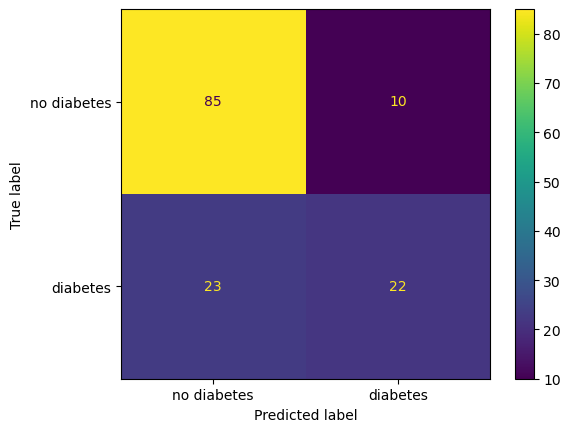

In [128]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no diabetes', 'diabetes'])
cm_disp.plot()
plt.show()

- The Logistic Regression classifier made a total of 140 predictioss out of those 140 cases, the classifier predictes 'yes' 32 times and 'no' 108 times
- In reality, 45 patients in sample have the diabetes, and 95 patients are non-daibetic.
    
    
- Recall or Sensitivity: when it's actully diabetic, how often does it predicted diabetic. TP / actual diabetic = 0.48%
    
- False Postiive(type1 error): When it's actually non-daibetic,how often does it predict diabetic. FP / actual no diabetic = 0.10%
    
- False Negative(type2 error) : When it's actully diabetic, how often it predicted non-diabetic.  FN/actual diabetic = 0.51%

- Precision: When it predicts diabetic, how often is it correct? TP / predicted diabetic = 0.68%
    
- f1_score: 2*precision*recall / precision+recall = 0.57



    


- from this outcome it is clear that LogisicRegression Classifier model gave false negative(type2 error) of 0.51% which didnot perfromed well, while detecting the actual cases of diabetes. 
However

In [109]:
from sklearn.metrics import recall_score, precision_score, f1_score
print("recall score",recall_score(y_test, y_pred))
print("precision score", precision_score(y_test,y_pred))
print("f1 score",f1_score(y_test,y_pred))

recall score 0.4888888888888889
precision score 0.6875
f1 score 0.5714285714285714


In [130]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84        95
           1       0.69      0.49      0.57        45

    accuracy                           0.76       140
   macro avg       0.74      0.69      0.70       140
weighted avg       0.76      0.76      0.75       140



#### Cross validation using Pipeline

In [103]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe,X_train,y_train,cv=5,scoring='accuracy').mean()

0.7581402831402831

#### Exporting the pipeline

In [271]:
# export
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))